# Backbone Torsion Cluster Visualization

Presentation-quality plots for the GMM-based backbone torsion clustering approach.

**Data source:** `../data/backbone_clusters.json` (pre-computed GMM parameters)  
**Raw data:** Re-collected for 4 representative edge types (cWW, tWW, tWH, cSS)

In [1]:
# Cell 1: Imports & data loading
import json
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.mixture import GaussianMixture
from pathlib import Path

# Resolve project root (one level up from notebooks/)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

# Import functions from the generation script
from generate_backbone_clusters import (
    load_unique_pdb_ids,
    get_excluded_pdb_ids,
    collect_backbone_data,
    angles_to_sincos,
    fit_gmm_with_bic,
    get_sugar_pucker,
    compute_mahalanobis_threshold,
    _vectorized_mahalanobis,
    MAX_GMM_K,
)

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams.update({"figure.dpi": 120, "savefig.dpi": 150})

# Load pre-computed cluster parameters (new pooled schema)
with open(PROJECT_ROOT / "data" / "backbone_clusters.json") as f:
    clusters_json = json.load(f)

global_clusters_data = clusters_json["global_clusters"]
edge_types_data = clusters_json["edge_types"]
print(f"Loaded global clusters: {list(global_clusters_data.keys())}")
for label, gc in global_clusters_data.items():
    print(f"  {label}: k={gc['n_components']}, n={gc['n_points']:,}")
print(f"Loaded weight profiles for {len(edge_types_data)} edge types")

# Collect raw torsion data for representative edge types
# This takes a few minutes
pdb_ids = load_unique_pdb_ids()
exclude = get_excluded_pdb_ids()
print(f"\nCollecting raw data from {len(pdb_ids - exclude)} PDBs...")
raw_data, raw_counts = collect_backbone_data(pdb_ids, exclude)

# Keep only the 4 edge types we need for plots
REPRESENTATIVE_EDGES = ["cWW", "tWW", "tWH", "cSS"]
raw_subset = {k: raw_data[k] for k in REPRESENTATIVE_EDGES if k in raw_data}
print(f"\nRaw data collected for: {list(raw_subset.keys())}")
for k, v in raw_subset.items():
    print(f"  {k}: {len(v):,} residue observations")

Loaded global clusters: ['abg_c3_endo', 'abg_c2_endo', 'dez']
  abg_c3_endo: k=15, n=1,532,745
  abg_c2_endo: k=19, n=171,022
  dez: k=14, n=1,707,799
Loaded weight profiles for 19 edge types

  Processed 500/2661 PDBs...
  Processed 1000/2661 PDBs...
  Processed 1500/2661 PDBs...
Processed 1859 PDBs with both basepairs and torsions
Skipped 802 (no basepairs), 0 (no torsions)

Raw data collected for: ['cWW', 'tWW', 'tWH', 'cSS']
  cWW: 1,132,570 residue observations
  tWW: 39,052 residue observations
  tWH: 62,726 residue observations
  cSS: 33,374 residue observations


In [2]:
# Cell 2: Overview table — global k + per-edge-type weight profiles

# Global cluster summary
print("GLOBAL CLUSTERS (shared across all edge types)")
print("=" * 50)
for label, gc in global_clusters_data.items():
    print(f"  {label}: k={gc['n_components']}, n={gc['n_points']:,}")

print(f"\nPER-EDGE-TYPE WEIGHT PROFILES")
print(f"{'Edge Type':<10} {'abg_c3_endo':>22} {'abg_c2_endo':>22} {'dez':>22} {'chi':>12}")
print("-" * 92)

for lw in sorted(edge_types_data.keys()):
    et = edge_types_data[lw]
    cols = []
    for group in ["abg_c3_endo", "abg_c2_endo", "dez"]:
        if group in et:
            g = et[group]
            top_w = max(g["weights"])
            cols.append(f"n={g['n_points']:,} top={top_w:.2f}")
        else:
            cols.append("--")
    if "chi" in et:
        cols.append(f"{et['chi']['modality'][:3]} n={et['chi']['count']:,}")
    else:
        cols.append("--")
    print(f"{lw:<10} {cols[0]:>22} {cols[1]:>22} {cols[2]:>22} {cols[3]:>12}")

GLOBAL CLUSTERS (shared across all edge types)
  abg_c3_endo: k=15, n=1,532,745
  abg_c2_endo: k=19, n=171,022
  dez: k=14, n=1,707,799

PER-EDGE-TYPE WEIGHT PROFILES
Edge Type             abg_c3_endo            abg_c2_endo                    dez          chi
--------------------------------------------------------------------------------------------
_OTHER          n=38,729 top=0.35      n=11,232 top=0.12      n=50,086 top=0.36 bim n=50,233
cHH              n=3,599 top=0.24       n=2,185 top=0.20       n=5,807 top=0.22  bim n=5,830
cHS              n=3,652 top=0.23       n=1,653 top=0.28       n=5,322 top=0.34  bim n=5,338
cHW              n=9,013 top=0.27       n=4,833 top=0.15      n=13,900 top=0.29 bim n=13,986
cSH             n=10,934 top=0.29       n=4,025 top=0.14      n=15,019 top=0.31 bim n=15,072
cSS             n=29,704 top=0.43       n=3,566 top=0.18      n=33,355 top=0.53 uni n=33,374
cSW             n=29,156 top=0.34       n=5,672 top=0.20      n=34,886 top=0.42 bim n=35,

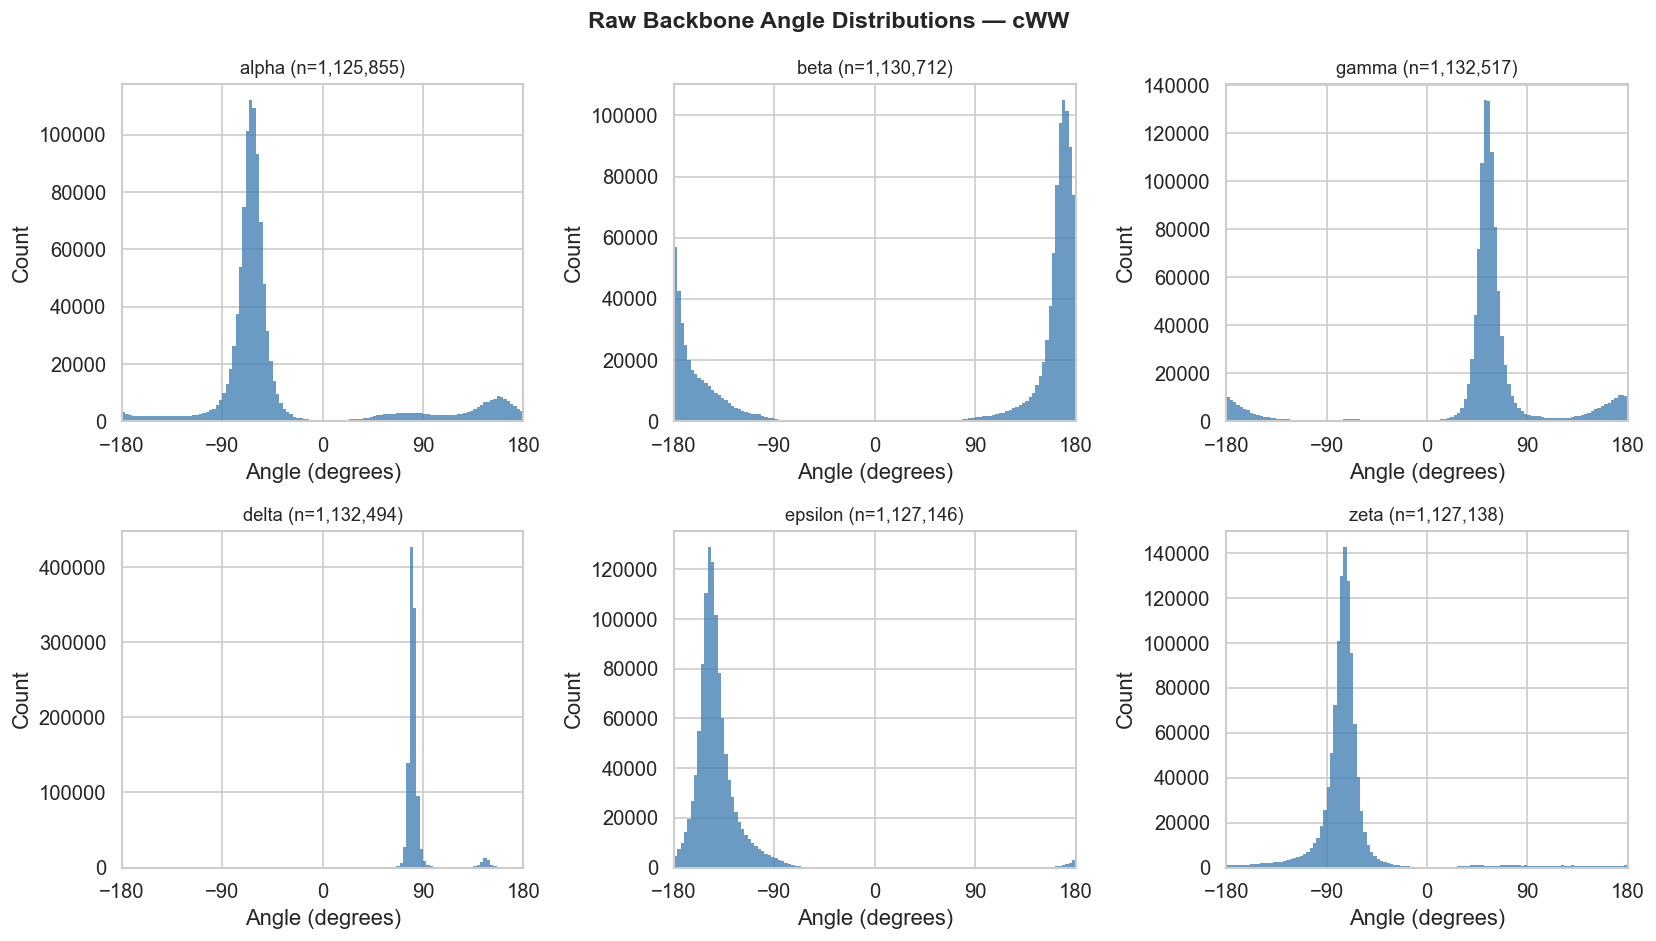

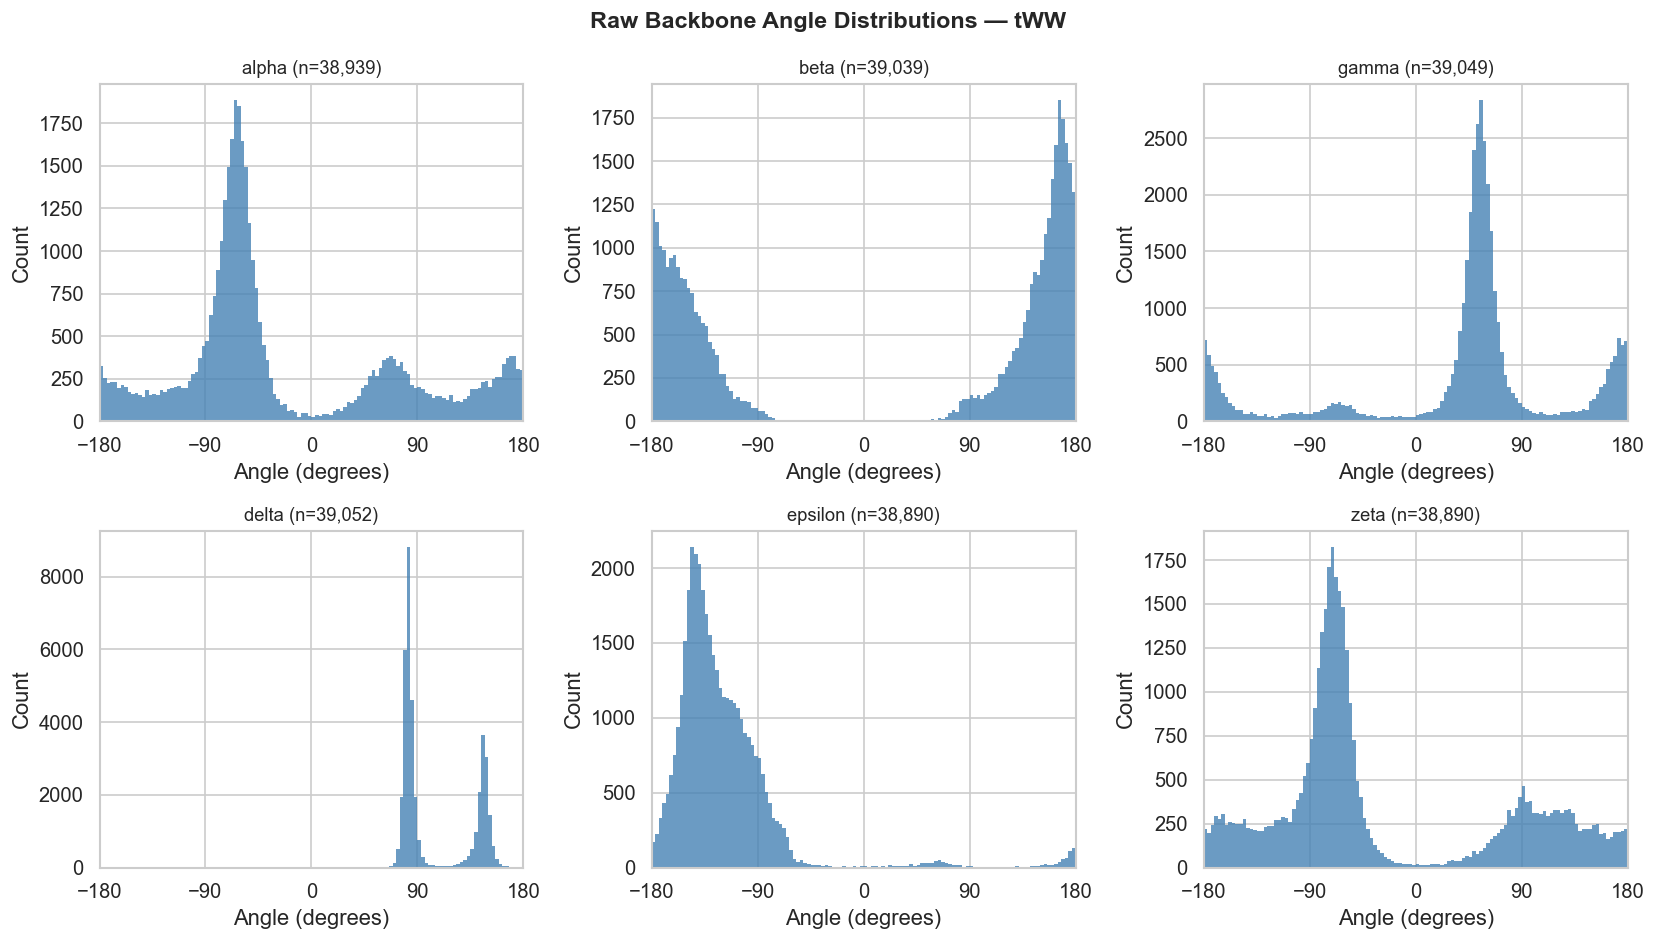

In [3]:
# Cell 3: Raw angle distributions (histograms)
# For cWW and tWW: 2x3 grid of histograms for alpha, beta, gamma, delta, epsilon, zeta

angle_names = ["alpha", "beta", "gamma", "delta", "epsilon", "zeta"]

for lw in ["cWW", "tWW"]:
    entries = raw_subset[lw]
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    fig.suptitle(f"Raw Backbone Angle Distributions — {lw}", fontsize=14, fontweight="bold")

    for idx, angle in enumerate(angle_names):
        ax = axes[idx // 3, idx % 3]
        vals = [e[angle] for e in entries if angle in e]
        if vals:
            ax.hist(vals, bins=120, range=(-180, 180), color="steelblue", alpha=0.8,
                    edgecolor="none")
        ax.set_title(f"{angle} (n={len(vals):,})", fontsize=11)
        ax.set_xlabel("Angle (degrees)")
        ax.set_ylabel("Count")
        ax.set_xlim(-180, 180)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(90))

    plt.tight_layout()
    plt.show()

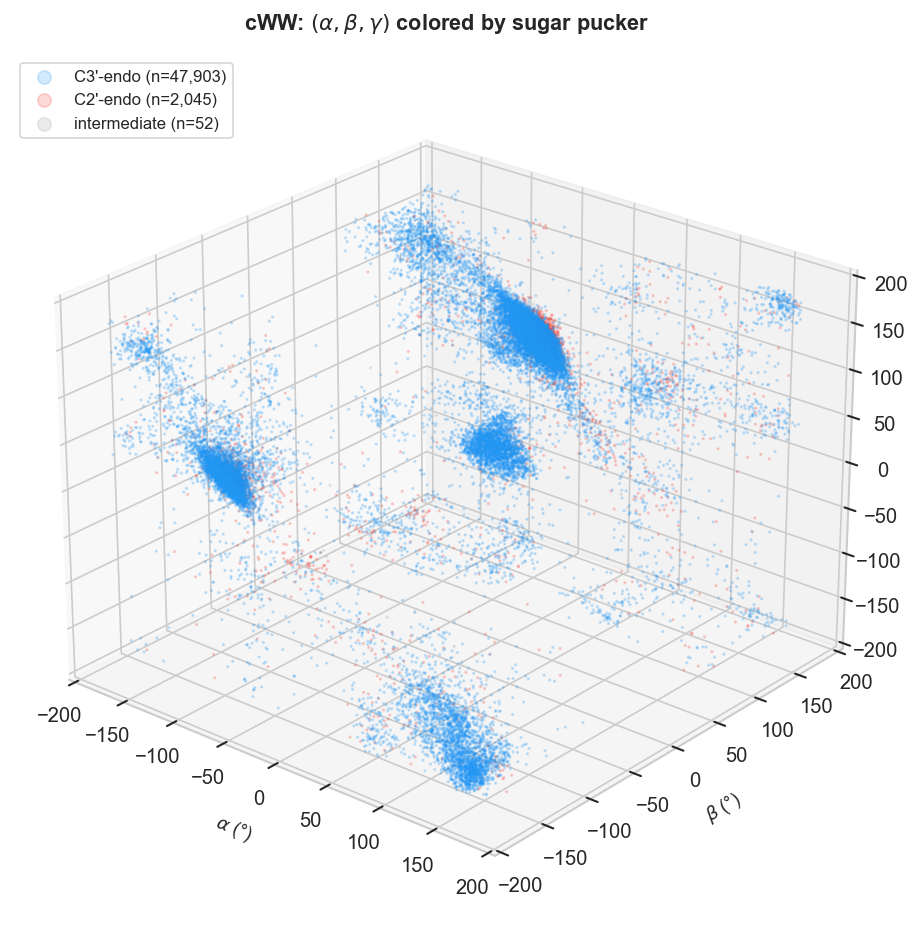

In [4]:
# Cell 4: Sugar pucker split visualization — 3D
# For cWW: 3D scatter of (alpha, beta, gamma) colored by sugar pucker

entries_cww = raw_subset["cWW"]

# Filter entries with alpha, beta, gamma, and delta
valid = [e for e in entries_cww if all(k in e for k in ("alpha", "beta", "gamma", "delta"))]

# Subsample for plotting performance
rng = np.random.RandomState(42)
if len(valid) > 50000:
    valid = [valid[i] for i in rng.choice(len(valid), 50000, replace=False)]

alpha = np.array([e["alpha"] for e in valid])
beta = np.array([e["beta"] for e in valid])
gamma = np.array([e["gamma"] for e in valid])
puckers = [get_sugar_pucker(e["delta"]) for e in valid]

pucker_colors = {"C3'-endo": "#2196F3", "C2'-endo": "#F44336", "intermediate": "#9E9E9E"}
pucker_order = ["C3'-endo", "C2'-endo", "intermediate"]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for pucker in pucker_order:
    mask = np.array([p == pucker for p in puckers])
    n = mask.sum()
    if n > 0:
        ax.scatter(alpha[mask], beta[mask], gamma[mask], s=1, alpha=0.2,
                   color=pucker_colors[pucker], label=f"{pucker} (n={n:,})",
                   rasterized=True)

ax.set_xlabel(r"$\alpha$ (°)", fontsize=11, labelpad=8)
ax.set_ylabel(r"$\beta$ (°)", fontsize=11, labelpad=8)
ax.set_zlabel(r"$\gamma$ (°)", fontsize=11, labelpad=8)
ax.set_title(r"cWW: $(\alpha, \beta, \gamma)$ colored by sugar pucker",
             fontsize=13, fontweight="bold", pad=15)
ax.legend(markerscale=8, fontsize=10, loc="upper left")
ax.view_init(elev=25, azim=-50)
plt.tight_layout()
plt.show()

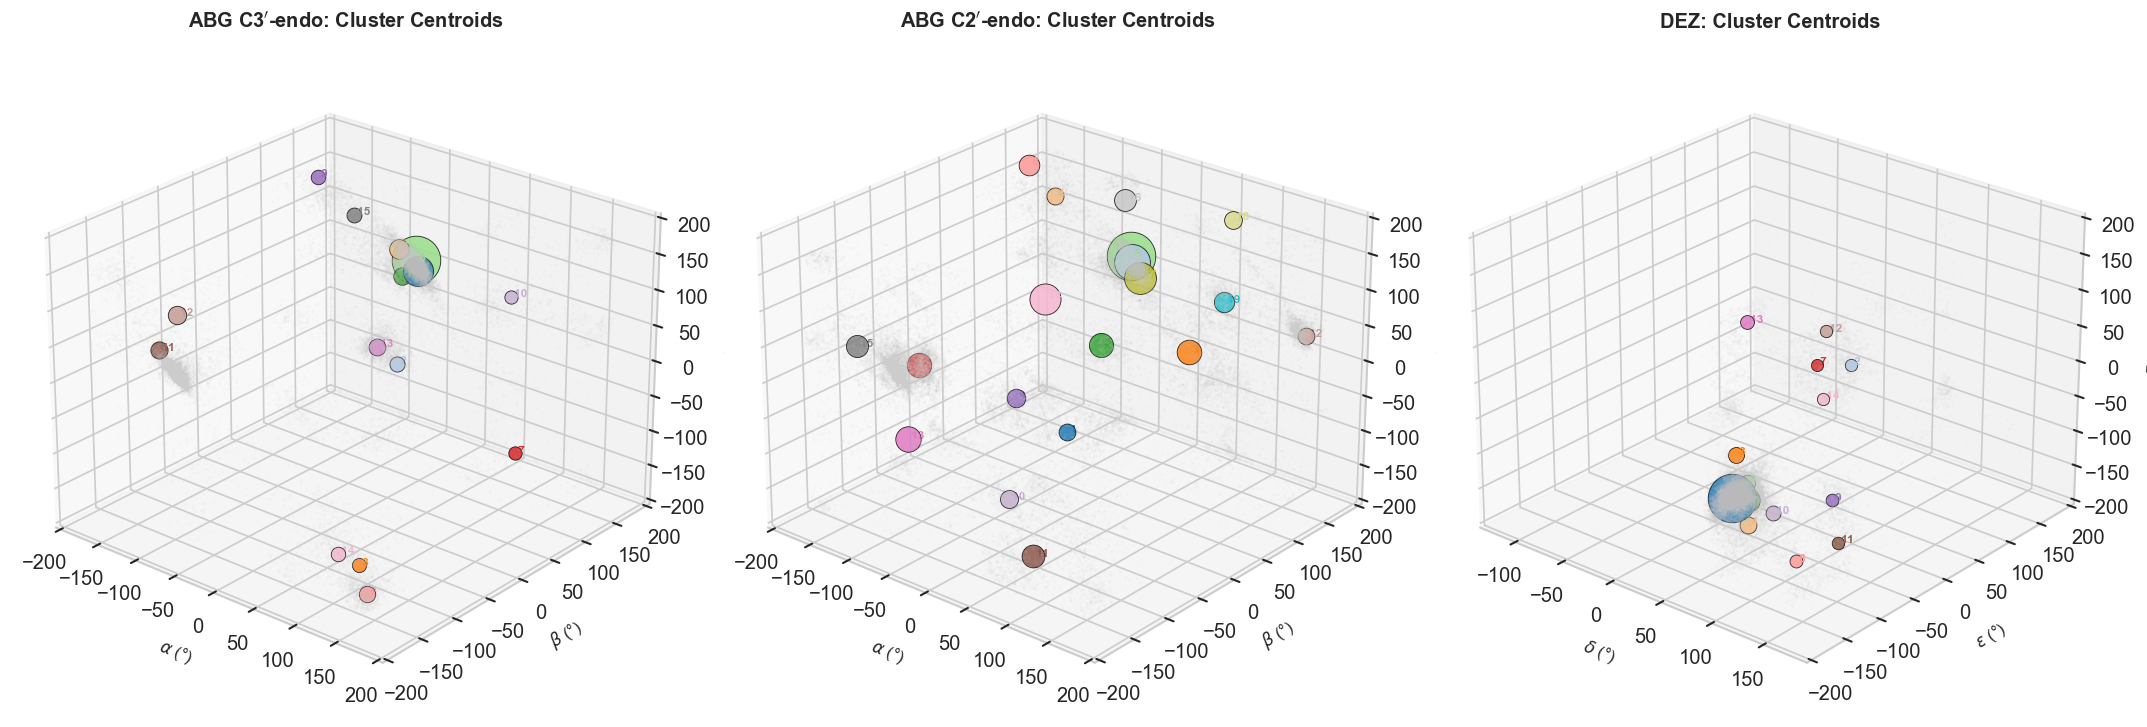


abg_c3_endo centroids (sorted by cWW weight):
    #   weight   angle1   angle2   angle3
    6   0.4929    -66.6    174.3     55.4
    1   0.1718    -52.3    159.8     51.3
    4   0.0550    -75.6    158.3     74.7
   12   0.0447    -69.2   -173.6    132.8
    5   0.0375    -65.2    151.5     43.4
   11   0.0352   -111.1   -155.2     60.0
   13   0.0325    157.9   -157.5    171.5
    8   0.0289    141.0   -150.0   -174.3
    2   0.0199    172.9   -148.0    150.9
   15   0.0187   -101.3    119.2    131.6
    9   0.0162   -160.1    133.3    159.5
   14   0.0156     99.8   -143.1   -140.2
    3   0.0138    100.9   -114.4   -171.6
    7   0.0089     63.1    174.5   -177.1
   10   0.0083     61.0    165.5     54.4

abg_c2_endo centroids (sorted by cWW weight):
    #   weight   angle1   angle2   angle3
    6   0.2315    -66.5    179.1     59.2
    2   0.1194    -51.0    161.9     64.1
   17   0.0915    -39.1    159.6     46.5
   14   0.0864   -175.6    174.6    -42.4
   13   0.0531    -68.2 

In [5]:
# Cell 4b: Cluster centroid diagnostic — are these clusters real?
# For each angle group: 3D scatter of raw data (grey) + cluster centroids (colored spheres)
# Centroid size proportional to weight. Overlapping centroids = likely over-splits.

def sincos_mean_to_angles(mean_6d):
    """Convert 6D sin/cos mean back to 3 angles in degrees."""
    angles = []
    for i in range(3):
        s, c = mean_6d[2*i], mean_6d[2*i+1]
        angles.append(np.degrees(np.arctan2(s, c)))
    return angles

# --- Helper to make one centroid plot ---
def plot_centroids(ax, raw_angles, centers_deg, weights, angle_labels, title, max_raw=30000):
    """Plot raw data as grey cloud + centroids as colored bubbles sized by weight."""
    rng_plot = np.random.RandomState(42)
    if len(raw_angles) > max_raw:
        idx = rng_plot.choice(len(raw_angles), max_raw, replace=False)
        raw_sub = raw_angles[idx]
    else:
        raw_sub = raw_angles

    # Raw data cloud
    ax.scatter(raw_sub[:, 0], raw_sub[:, 1], raw_sub[:, 2],
               s=0.5, alpha=0.05, color="#CCCCCC", rasterized=True)

    # Centroids — size by weight, color by index
    cmap = plt.cm.tab20 if len(centers_deg) > 10 else plt.cm.tab10
    sizes = np.array(weights) / max(weights) * 800 + 50  # scale for visibility
    for i, (center, w, sz) in enumerate(zip(centers_deg, weights, sizes)):
        ax.scatter([center[0]], [center[1]], [center[2]],
                   s=sz, color=cmap(i % 20), edgecolors="black", linewidths=0.5,
                   alpha=0.85, zorder=10)
        ax.text(center[0], center[1], center[2], f" {i+1}", fontsize=7,
                color=cmap(i % 20), fontweight="bold", zorder=11)

    ax.set_xlabel(f"{angle_labels[0]} (°)", fontsize=10, labelpad=6)
    ax.set_ylabel(f"{angle_labels[1]} (°)", fontsize=10, labelpad=6)
    ax.set_zlabel(f"{angle_labels[2]} (°)", fontsize=10, labelpad=6)
    ax.set_title(title, fontsize=12, fontweight="bold", pad=12)
    ax.view_init(elev=25, azim=-50)


# Collect pooled raw angles for each group
abg_c3_raw, abg_c2_raw, dez_raw = [], [], []
for entries in raw_data.values():
    for e in entries:
        if all(k in e for k in ("alpha", "beta", "gamma", "delta")):
            pucker = get_sugar_pucker(e["delta"])
            triple = [e["alpha"], e["beta"], e["gamma"]]
            if pucker == "C3'-endo":
                abg_c3_raw.append(triple)
            elif pucker == "C2'-endo":
                abg_c2_raw.append(triple)
        if all(k in e for k in ("delta", "epsilon", "zeta")):
            dez_raw.append([e["delta"], e["epsilon"], e["zeta"]])

abg_c3_raw = np.array(abg_c3_raw)
abg_c2_raw = np.array(abg_c2_raw)
dez_raw = np.array(dez_raw)

# Convert cluster means from sin/cos to degrees + get cWW weights as reference
groups = [
    ("abg_c3_endo", abg_c3_raw, [r"$\alpha$", r"$\beta$", r"$\gamma$"],
     r"ABG C3$'$-endo: Cluster Centroids"),
    ("abg_c2_endo", abg_c2_raw, [r"$\alpha$", r"$\beta$", r"$\gamma$"],
     r"ABG C2$'$-endo: Cluster Centroids"),
    ("dez", dez_raw, [r"$\delta$", r"$\epsilon$", r"$\zeta$"],
     r"DEZ: Cluster Centroids"),
]

fig = plt.figure(figsize=(18, 6))
for plot_idx, (group_label, raw_arr, angle_labels, title) in enumerate(groups):
    gc = global_clusters_data[group_label]
    centers_deg = [sincos_mean_to_angles(c["mean"]) for c in gc["clusters"]]

    # Use cWW weights as the size reference (largest edge type)
    cww_weights = edge_types_data["cWW"][group_label]["weights"]

    ax = fig.add_subplot(1, 3, plot_idx + 1, projection="3d")
    plot_centroids(ax, raw_arr, centers_deg, cww_weights, angle_labels, title)

plt.tight_layout()
plt.show()

# Print centroid positions sorted by weight for quick inspection
for group_label in ("abg_c3_endo", "abg_c2_endo", "dez"):
    gc = global_clusters_data[group_label]
    cww_w = edge_types_data["cWW"][group_label]["weights"]
    centers = [sincos_mean_to_angles(c["mean"]) for c in gc["clusters"]]
    print(f"\n{group_label} centroids (sorted by cWW weight):")
    print(f"  {'#':>3}  {'weight':>7}  {'angle1':>7}  {'angle2':>7}  {'angle3':>7}")
    for i, (w, c) in sorted(enumerate(zip(cww_w, centers)),
                              key=lambda x: -x[1][0]):
        print(f"  {i+1:>3}  {w:>7.4f}  {c[0]:>7.1f}  {c[1]:>7.1f}  {c[2]:>7.1f}")

In [ ]:
# Cell 5: Global GMM clusters — (alpha, beta, gamma) C3'-endo
# Reconstruct GMM from global_clusters, color ALL pooled data by global cluster

# Reconstruct GMM from stored global params
gc_abg = global_clusters_data["abg_c3_endo"]
n_k = gc_abg["n_components"]

gmm_abg = GaussianMixture(n_components=n_k, covariance_type="full")
gmm_abg.means_ = np.array([c["mean"] for c in gc_abg["clusters"]])
gmm_abg.covariances_ = np.array([c["covariance"] for c in gc_abg["clusters"]])
gmm_abg.weights_ = np.ones(n_k) / n_k  # uniform (weights are edge-specific)
gmm_abg.precisions_cholesky_ = np.linalg.cholesky(
    np.linalg.inv(gmm_abg.covariances_)
)

# Collect ALL C3'-endo ABG data across edge types for display
all_c3_entries = []
for entries in raw_data.values():
    for e in entries:
        if all(k in e for k in ("alpha", "beta", "gamma", "delta")):
            if get_sugar_pucker(e["delta"]) == "C3'-endo":
                all_c3_entries.append(e)

angles_abg = np.array([[e["alpha"], e["beta"], e["gamma"]] for e in all_c3_entries])
X_abg = angles_to_sincos(angles_abg)
labels_abg = gmm_abg.predict(X_abg)
print(f"Global C3'-endo ABG: {len(all_c3_entries):,} points, {n_k} clusters")

# Subsample for plotting
rng = np.random.RandomState(42)
max_plot = 50000
if len(angles_abg) > max_plot:
    idx = rng.choice(len(angles_abg), max_plot, replace=False)
    ang_plot = angles_abg[idx]
    labels_plot = labels_abg[idx]
else:
    ang_plot = angles_abg
    labels_plot = labels_abg

cluster_cmap = plt.cm.tab20 if n_k > 10 else plt.cm.tab10

fig = plt.figure(figsize=(11, 9))
ax3d = fig.add_subplot(111, projection="3d")

for k in range(n_k):
    mask = labels_plot == k
    ax3d.scatter(ang_plot[mask, 0], ang_plot[mask, 1], ang_plot[mask, 2],
                 s=1, alpha=0.2, color=cluster_cmap(k), rasterized=True)

ax3d.set_xlabel(r"$\alpha$ (°)", fontsize=11, labelpad=8)
ax3d.set_ylabel(r"$\beta$ (°)", fontsize=11, labelpad=8)
ax3d.set_zlabel(r"$\gamma$ (°)", fontsize=11, labelpad=8)
ax3d.set_title(r"Global C3$'$-endo: Pooled GMM Clusters in $(\alpha,\beta,\gamma)$ space",
               fontsize=13, fontweight="bold", pad=15)
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=cluster_cmap(k),
                       markersize=8, label=f"Cluster {k+1}") for k in range(n_k)]
ax3d.legend(handles=handles, fontsize=9, loc="upper left",
            ncol=2 if n_k > 8 else 1)
ax3d.view_init(elev=25, azim=-50)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 6: Global GMM clusters — (delta, epsilon, zeta)
# Reconstruct GMM from global_clusters, color ALL pooled data by global cluster

# Reconstruct GMM from stored global params
gc_dez = global_clusters_data["dez"]
n_k_dez = gc_dez["n_components"]

gmm_dez = GaussianMixture(n_components=n_k_dez, covariance_type="full")
gmm_dez.means_ = np.array([c["mean"] for c in gc_dez["clusters"]])
gmm_dez.covariances_ = np.array([c["covariance"] for c in gc_dez["clusters"]])
gmm_dez.weights_ = np.ones(n_k_dez) / n_k_dez
gmm_dez.precisions_cholesky_ = np.linalg.cholesky(
    np.linalg.inv(gmm_dez.covariances_)
)

# Collect ALL DEZ data across edge types
all_dez_entries = []
for entries in raw_data.values():
    for e in entries:
        if all(k in e for k in ("delta", "epsilon", "zeta")):
            all_dez_entries.append(e)

angles_dez = np.array([[e["delta"], e["epsilon"], e["zeta"]] for e in all_dez_entries])
X_dez = angles_to_sincos(angles_dez)
labels_dez = gmm_dez.predict(X_dez)
print(f"Global DEZ: {len(all_dez_entries):,} points, {n_k_dez} clusters")

# Subsample
rng = np.random.RandomState(42)
max_plot = 50000
if len(angles_dez) > max_plot:
    idx = rng.choice(len(angles_dez), max_plot, replace=False)
    ang_plot_dez = angles_dez[idx]
    labels_plot_dez = labels_dez[idx]
else:
    ang_plot_dez = angles_dez
    labels_plot_dez = labels_dez

cluster_cmap = plt.cm.tab20 if n_k_dez > 10 else plt.cm.tab10

fig = plt.figure(figsize=(11, 9))
ax3d = fig.add_subplot(111, projection="3d")

for k in range(n_k_dez):
    mask = labels_plot_dez == k
    ax3d.scatter(ang_plot_dez[mask, 0], ang_plot_dez[mask, 1], ang_plot_dez[mask, 2],
                 s=1, alpha=0.2, color=cluster_cmap(k), rasterized=True)

ax3d.set_xlabel(r"$\delta$ (°)", fontsize=11, labelpad=8)
ax3d.set_ylabel(r"$\epsilon$ (°)", fontsize=11, labelpad=8)
ax3d.set_zlabel(r"$\zeta$ (°)", fontsize=11, labelpad=8)
ax3d.set_title(r"Global: Pooled GMM Clusters in $(\delta,\epsilon,\zeta)$ space",
               fontsize=13, fontweight="bold", pad=15)
handles_dez = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=cluster_cmap(k),
                           markersize=8, label=f"Cluster {k+1}") for k in range(n_k_dez)]
ax3d.legend(handles=handles_dez, fontsize=9, loc="upper left",
            ncol=2 if n_k_dez > 8 else 1)
ax3d.view_init(elev=25, azim=-50)
plt.tight_layout()
plt.show()

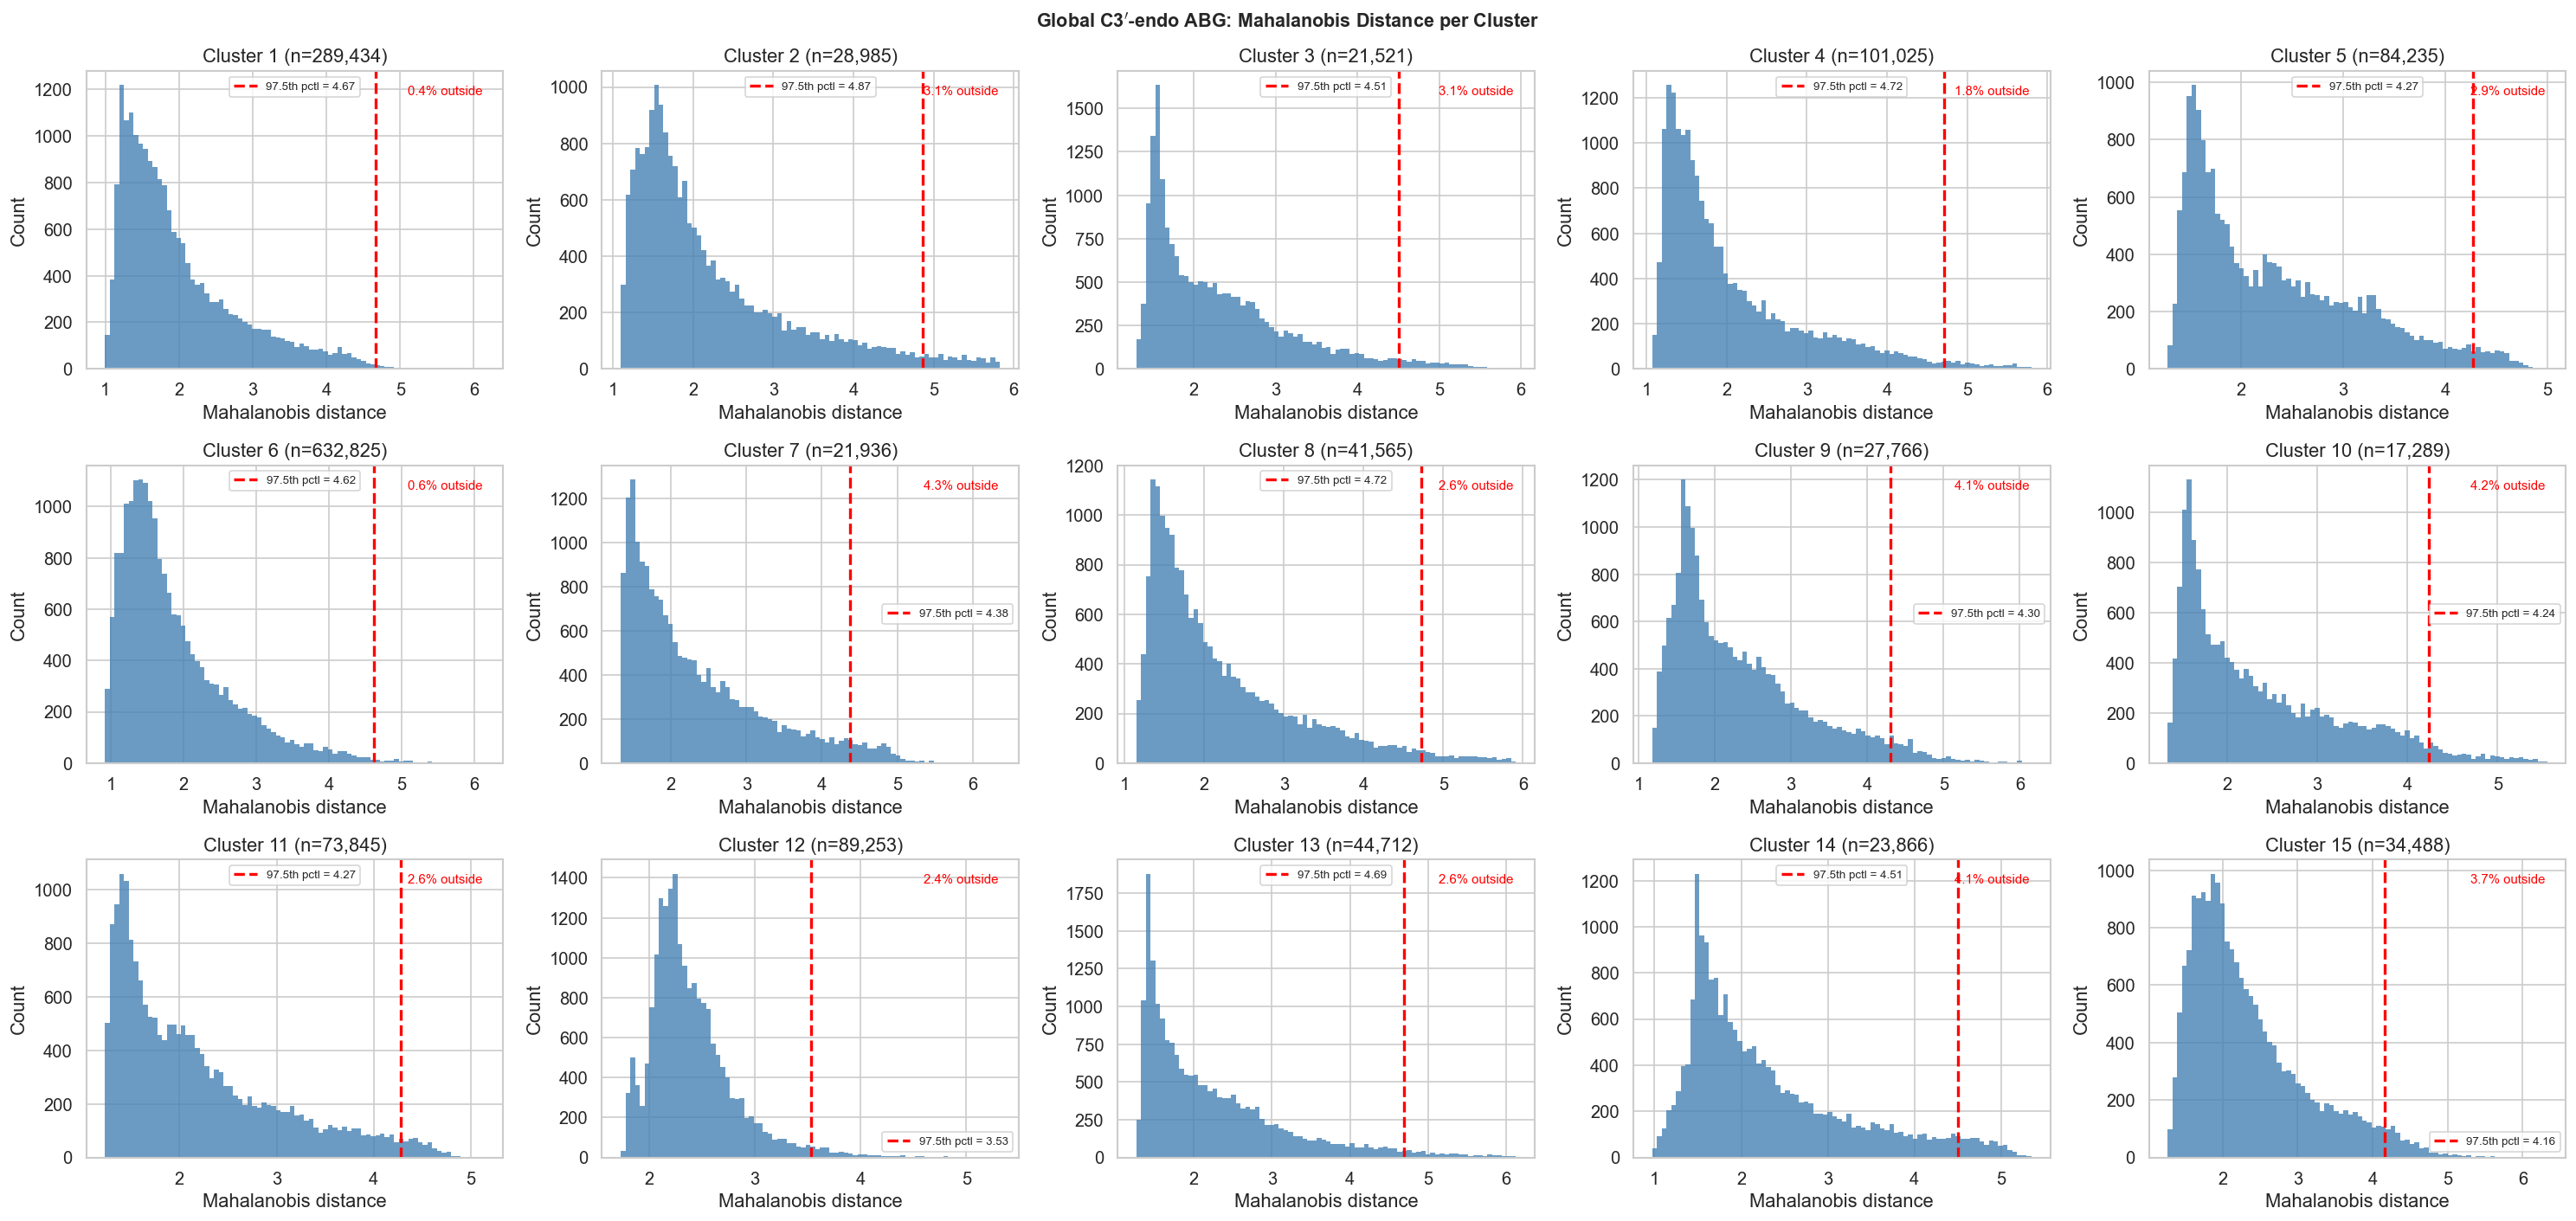

In [8]:
# Cell 7: Mahalanobis distance distributions
# For global abg_c3_endo: histogram of Mahalanobis distances per cluster

# Re-use the reconstructed GMM and pooled data from cell 5
thresholds_abg = [c["mahalanobis_threshold"] for c in gc_abg["clusters"]]

n_cols = min(n_k, 5)
n_rows = (n_k + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
fig.suptitle(r"Global C3$'$-endo ABG: Mahalanobis Distance per Cluster",
             fontsize=13, fontweight="bold")

for k in range(n_k):
    ax = axes[k // n_cols, k % n_cols]
    mask = labels_abg == k
    pts = X_abg[mask]
    mean_k = gmm_abg.means_[k]
    cov_k = gmm_abg.covariances_[k]
    try:
        cov_inv = np.linalg.inv(cov_k)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov_k)

    # Subsample for speed if cluster is large
    if len(pts) > 20000:
        rng_mah = np.random.RandomState(42)
        sub_idx = rng_mah.choice(len(pts), 20000, replace=False)
        pts_sub = pts[sub_idx]
    else:
        pts_sub = pts
    dists = _vectorized_mahalanobis(pts_sub, mean_k, cov_inv)
    thr = thresholds_abg[k]
    frac_outside = np.mean(dists > thr) * 100

    ax.hist(dists, bins=80, color="steelblue", alpha=0.8, edgecolor="none")
    ax.axvline(thr, color="red", linestyle="--", linewidth=2,
               label=f"97.5th pctl = {thr:.2f}")
    ax.set_title(f"Cluster {k+1} (n={mask.sum():,})")
    ax.set_xlabel("Mahalanobis distance")
    ax.set_ylabel("Count")
    ax.legend(fontsize=8)
    ax.annotate(f"{frac_outside:.1f}% outside", xy=(0.95, 0.92),
                xycoords="axes fraction", ha="right", fontsize=9, color="red")

# Hide unused subplots
for k in range(n_k, n_rows * n_cols):
    axes[k // n_cols, k % n_cols].set_visible(False)

plt.tight_layout()
plt.show()

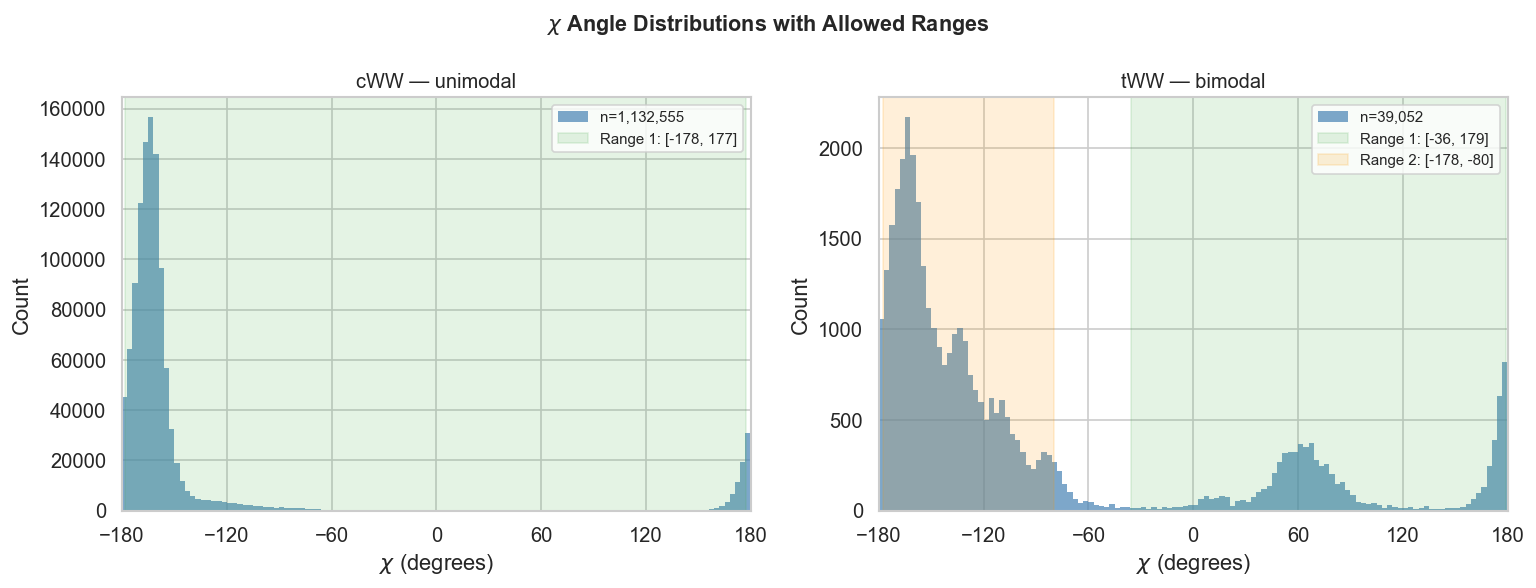

In [9]:
# Cell 8: Chi angle analysis
# For cWW (unimodal) and tWW (bimodal): chi histograms with shaded allowed ranges

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(r"$\chi$ Angle Distributions with Allowed Ranges", fontsize=13, fontweight="bold")

for idx, lw in enumerate(["cWW", "tWW"]):
    ax = axes[idx]
    entries = raw_subset[lw]
    chi_vals = np.array([e["chi"] for e in entries if "chi" in e])

    ax.hist(chi_vals, bins=120, range=(-180, 180), color="steelblue", alpha=0.7,
            edgecolor="none", label=f"n={len(chi_vals):,}")

    # Overlay allowed ranges from clusters_json
    if lw in edge_types_data and "chi" in edge_types_data[lw]:
        chi_info = edge_types_data[lw]["chi"]
        colors_range = ["#4CAF50", "#FF9800"]
        for r_idx, rng_val in enumerate(chi_info["ranges"]):
            ax.axvspan(rng_val[0], rng_val[1], alpha=0.15, color=colors_range[r_idx % 2],
                       label=f"Range {r_idx+1}: [{rng_val[0]:.0f}, {rng_val[1]:.0f}]")
        modality = chi_info["modality"]
    else:
        modality = "N/A"

    ax.set_title(f"{lw} — {modality}", fontsize=12)
    ax.set_xlabel(r"$\chi$ (degrees)")
    ax.set_ylabel("Count")
    ax.set_xlim(-180, 180)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

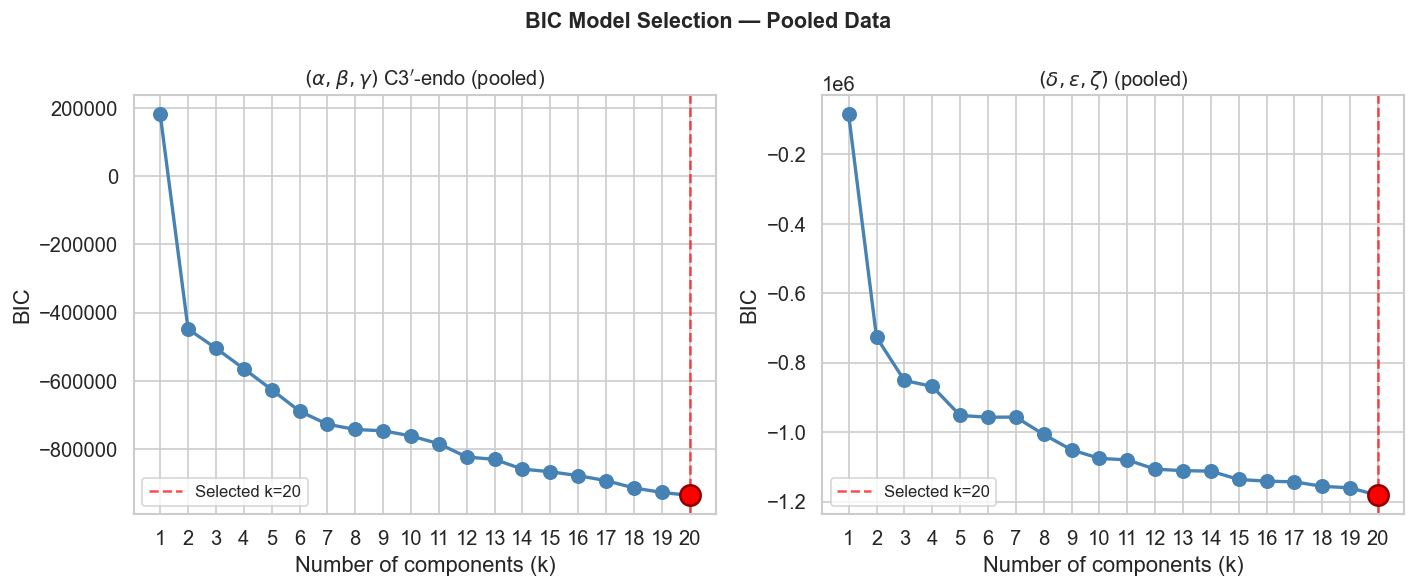

In [10]:
# Cell 9: BIC model selection on POOLED data
# Fit on subsampled pooled ABG C3'-endo and pooled DEZ datasets up to k=MAX_GMM_K

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("BIC Model Selection — Pooled Data", fontsize=13, fontweight="bold")

datasets = [
    (r"$(\alpha,\beta,\gamma)$ C3$'$-endo (pooled)", X_abg),
    (r"$(\delta,\epsilon,\zeta)$ (pooled)", X_dez),
]

for ax, (title, X) in zip(axes, datasets):
    # Subsample for BIC fitting speed
    if len(X) > 50000:
        rng_bic = np.random.RandomState(42)
        X_bic = X[rng_bic.choice(len(X), 50000, replace=False)]
    else:
        X_bic = X
    bics = []
    ks = list(range(1, MAX_GMM_K + 1))
    for k in ks:
        gmm = GaussianMixture(n_components=k, covariance_type="full",
                              random_state=42, max_iter=200, n_init=1)
        gmm.fit(X_bic)
        bics.append(gmm.bic(X_bic))

    best_k = ks[np.argmin(bics)]

    ax.plot(ks, bics, "o-", color="steelblue", linewidth=2, markersize=8)
    ax.axvline(best_k, color="red", linestyle="--", alpha=0.7,
               label=f"Selected k={best_k}")
    ax.scatter([best_k], [bics[best_k - 1]], s=150, color="red", zorder=5,
               edgecolors="darkred", linewidths=1.5)
    ax.set_xlabel("Number of components (k)")
    ax.set_ylabel("BIC")
    ax.set_title(title, fontsize=12)
    ax.set_xticks(ks)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

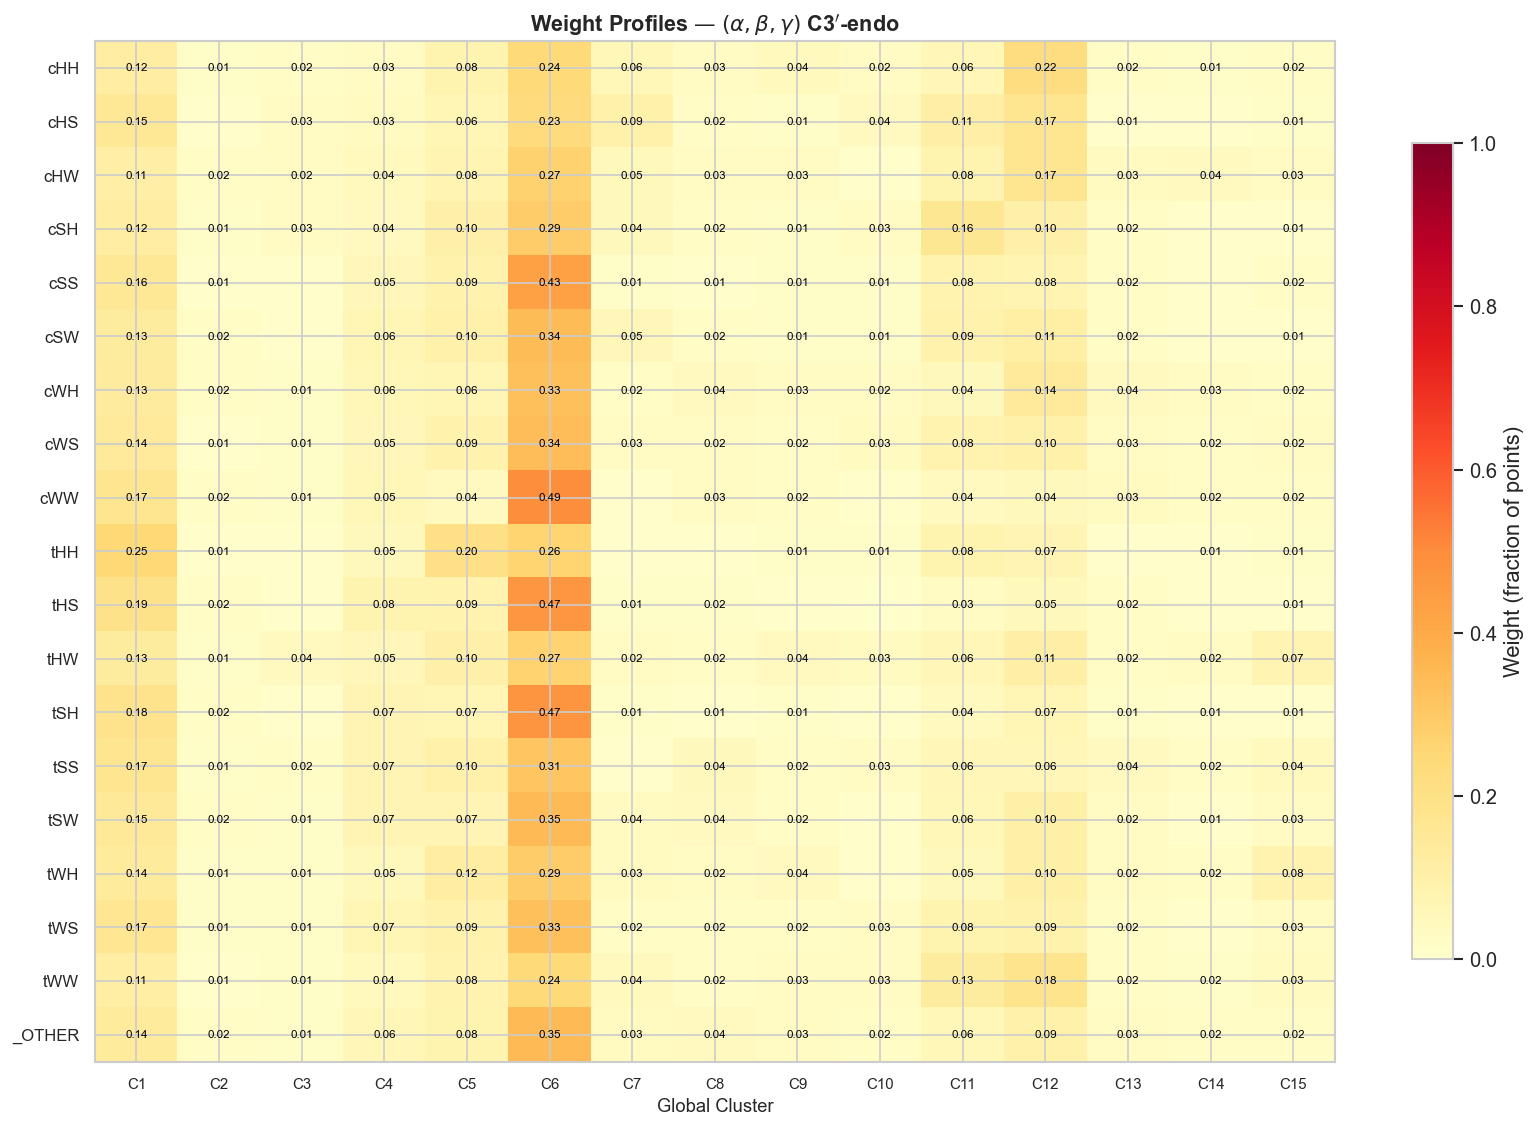

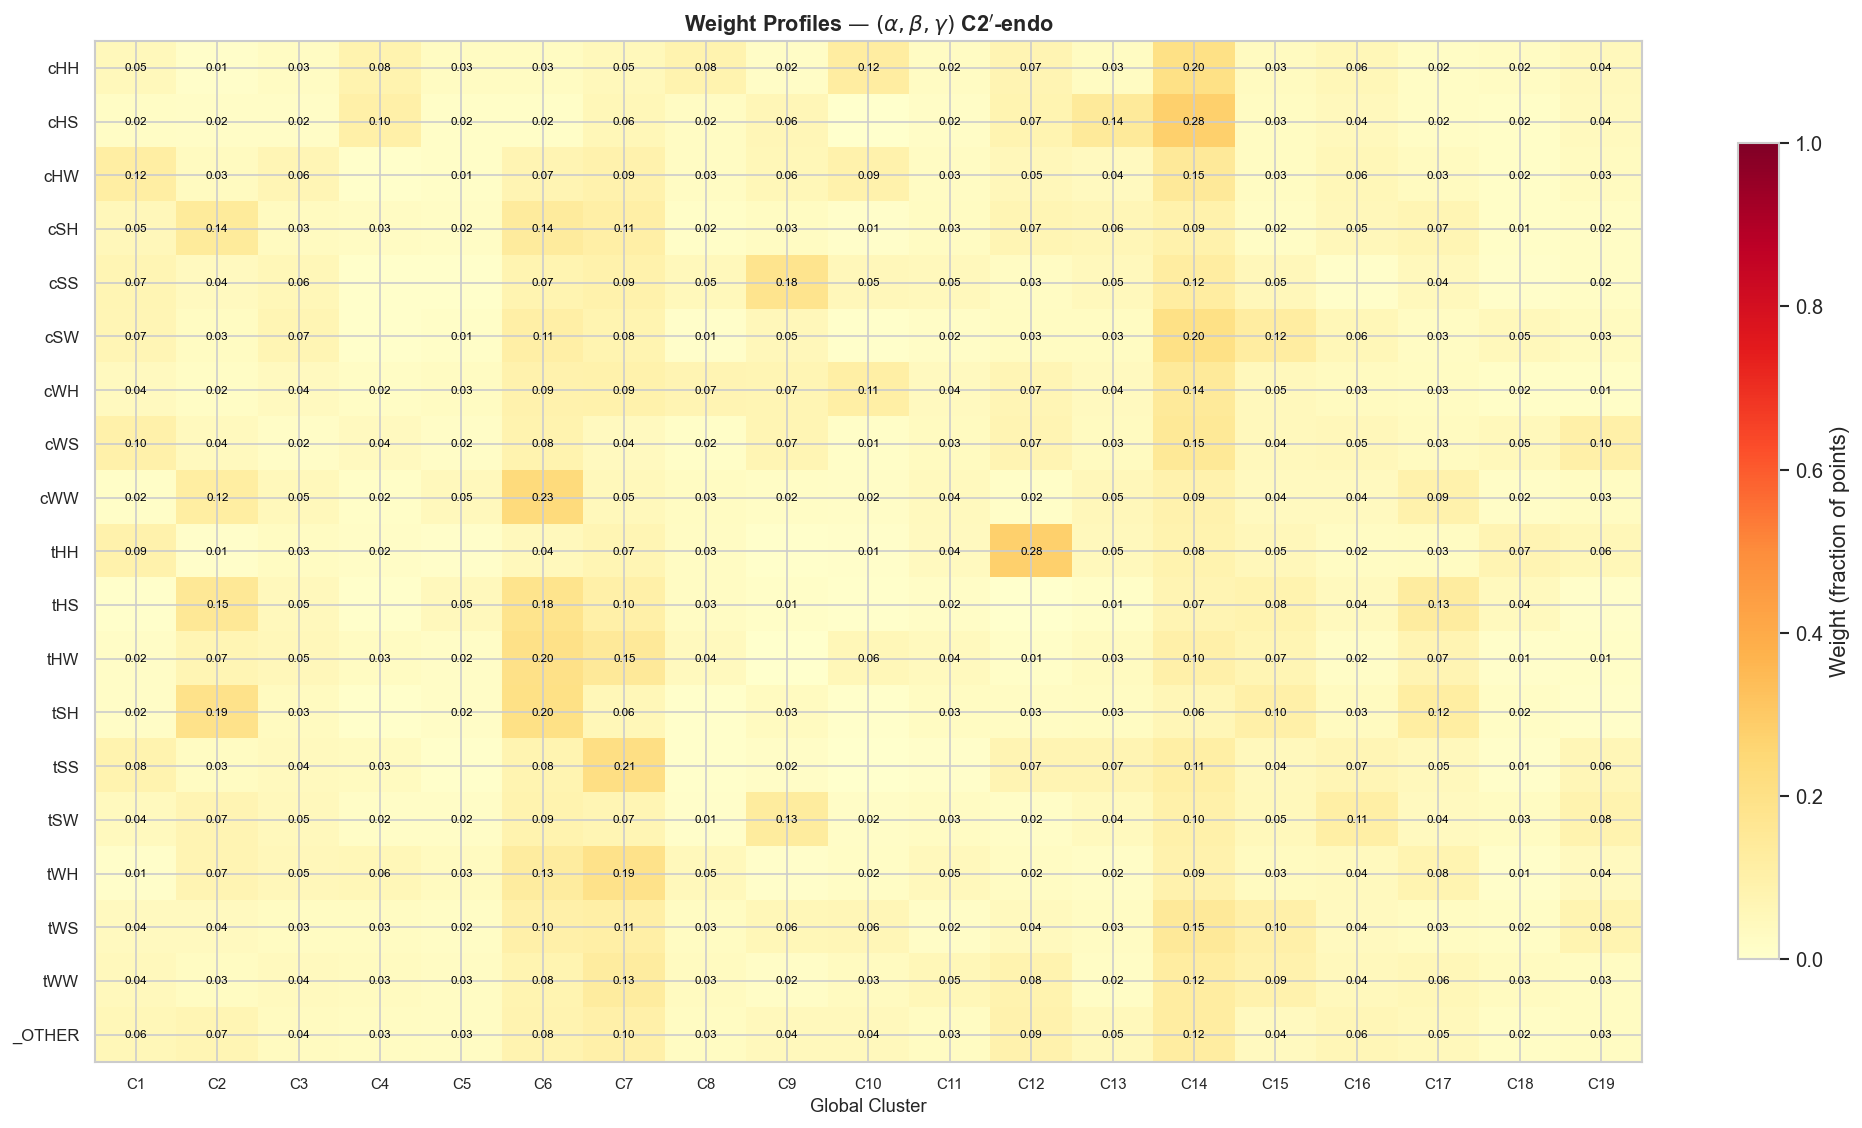

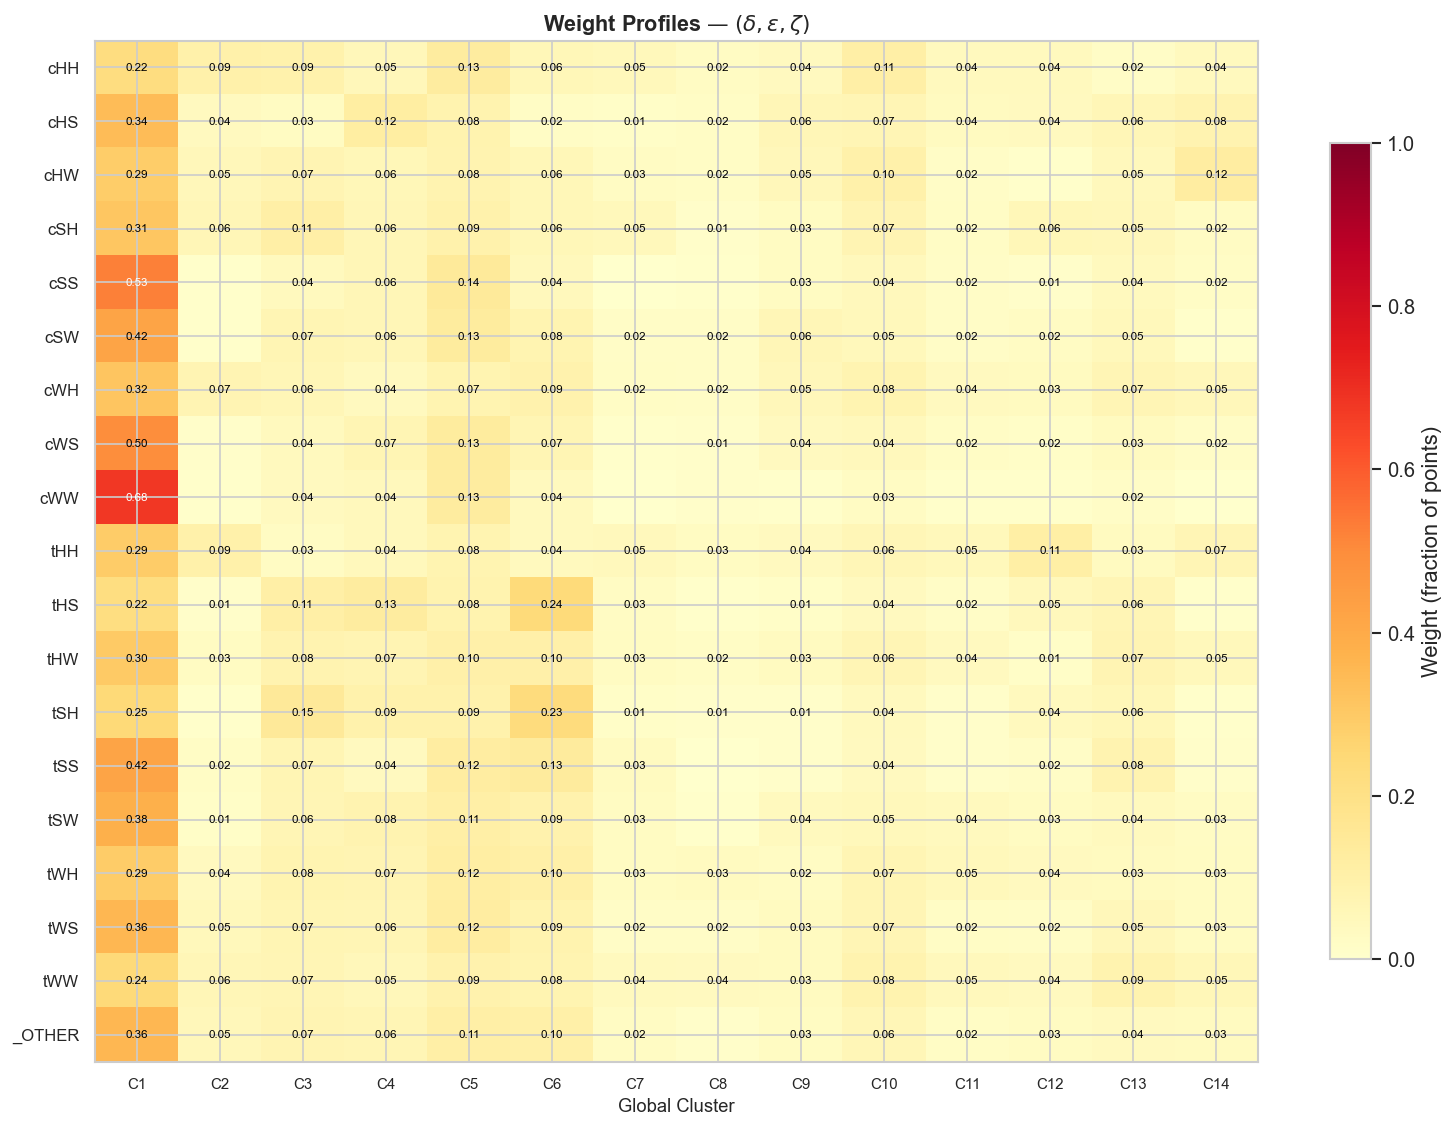

In [11]:
# Cell 10: Cross-edge-type comparison — weight profile heatmaps
# Shows which global conformations each edge type prefers

edge_list = sorted([k for k in edge_types_data.keys() if k != "_OTHER"])
edge_list.append("_OTHER")

for group_label, group_title in [
    ("abg_c3_endo", r"$(\alpha,\beta,\gamma)$ C3$'$-endo"),
    ("abg_c2_endo", r"$(\alpha,\beta,\gamma)$ C2$'$-endo"),
    ("dez", r"$(\delta,\epsilon,\zeta)$"),
]:
    if group_label not in global_clusters_data:
        continue
    n_clusters = global_clusters_data[group_label]["n_components"]

    # Build weight matrix: edge_types x clusters
    valid_edges = []
    weight_matrix = []
    for lw in edge_list:
        if lw in edge_types_data and group_label in edge_types_data[lw]:
            valid_edges.append(lw)
            weight_matrix.append(edge_types_data[lw][group_label]["weights"])

    if not weight_matrix:
        continue

    weight_matrix = np.array(weight_matrix)

    fig, ax = plt.subplots(figsize=(max(8, n_clusters * 0.8 + 2), len(valid_edges) * 0.4 + 2))
    im = ax.imshow(weight_matrix, aspect="auto", cmap="YlOrRd", vmin=0, vmax=1)

    ax.set_xticks(range(n_clusters))
    ax.set_xticklabels([f"C{k+1}" for k in range(n_clusters)], fontsize=9)
    ax.set_yticks(range(len(valid_edges)))
    ax.set_yticklabels(valid_edges, fontsize=10)
    ax.set_xlabel("Global Cluster", fontsize=11)
    ax.set_title(f"Weight Profiles — {group_title}", fontsize=13, fontweight="bold")

    # Annotate cells with weight values
    for i in range(len(valid_edges)):
        for j in range(n_clusters):
            w = weight_matrix[i, j]
            if w >= 0.01:
                color = "white" if w > 0.5 else "black"
                ax.text(j, i, f"{w:.2f}", ha="center", va="center",
                        fontsize=7, color=color)

    plt.colorbar(im, ax=ax, label="Weight (fraction of points)", shrink=0.8)
    plt.tight_layout()
    plt.show()

In [12]:
# Cell 11: Pooled cluster summary
# With pooled clustering, clusters are unique by construction — no deduplication needed

print("POOLED CLUSTER SUMMARY")
print("=" * 60)
print("Clusters are shared across all edge types (unique by construction).\n")

for label, gc in global_clusters_data.items():
    n_k = gc["n_components"]
    n_pts = gc["n_points"]
    print(f"{label}:")
    print(f"  {n_k} global clusters fitted on {n_pts:,} pooled data points")

    # Show cluster sizes (from global threshold data — approximated via weight sums)
    thresholds = [c["mahalanobis_threshold"] for c in gc["clusters"]]
    for i, cl in enumerate(gc["clusters"]):
        print(f"    Cluster {i+1}: Mahalanobis threshold = {cl['mahalanobis_threshold']:.2f}")
    print()

# Weight distribution summary across edge types
print("WEIGHT DISTRIBUTION ACROSS EDGE TYPES")
print("=" * 60)
for group_label in ("abg_c3_endo", "abg_c2_endo", "dez"):
    if group_label not in global_clusters_data:
        continue
    n_k = global_clusters_data[group_label]["n_components"]
    print(f"\n{group_label} ({n_k} clusters):")

    # For each edge type, find the dominant cluster
    for lw in sorted(edge_types_data.keys()):
        et = edge_types_data[lw]
        if group_label not in et:
            continue
        weights = et[group_label]["weights"]
        dominant = np.argmax(weights)
        w_sum = sum(weights)
        print(f"  {lw:>8s}: dominant=C{dominant+1} ({weights[dominant]:.2f}), "
              f"weight_sum={w_sum:.4f}")

POOLED CLUSTER SUMMARY
Clusters are shared across all edge types (unique by construction).

abg_c3_endo:
  15 global clusters fitted on 1,532,745 pooled data points
    Cluster 1: Mahalanobis threshold = 4.67
    Cluster 2: Mahalanobis threshold = 4.87
    Cluster 3: Mahalanobis threshold = 4.51
    Cluster 4: Mahalanobis threshold = 4.72
    Cluster 5: Mahalanobis threshold = 4.27
    Cluster 6: Mahalanobis threshold = 4.62
    Cluster 7: Mahalanobis threshold = 4.38
    Cluster 8: Mahalanobis threshold = 4.72
    Cluster 9: Mahalanobis threshold = 4.30
    Cluster 10: Mahalanobis threshold = 4.24
    Cluster 11: Mahalanobis threshold = 4.27
    Cluster 12: Mahalanobis threshold = 3.53
    Cluster 13: Mahalanobis threshold = 4.69
    Cluster 14: Mahalanobis threshold = 4.51
    Cluster 15: Mahalanobis threshold = 4.16

abg_c2_endo:
  19 global clusters fitted on 171,022 pooled data points
    Cluster 1: Mahalanobis threshold = 4.28
    Cluster 2: Mahalanobis threshold = 4.26
    Clust